# Hyperparamètre et Sélection de features

Dans ce notebook:
* Traitement des valeurs manquantes avec **IterativeImputer**
* Recherche d'hyperparamètre pour une **classification KNeighbors** avec **GridSearch**
* Sélection de features réalisée en utilisant **Chi2**

## Préparation

Préalablement à cette sélection de variables, il faut manipuler l'ensemble des données:
* Réduire le jeu de données pour l'exercice et ne considérer que quelques features.
* Traiter les données manquantes avec un  *IterativeImputer* pour rendre le dataset utilisable.
* Modifier le typage de certaines données.

### Chargement du Dataset

In [106]:
import pandas as pds

titanic = pds.read_excel(r"titanic3.xls")

pds.set_option('display.max_rows', None)

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


### Réduction des features

In [107]:
# reducing dataset
sub_titanic = titanic[["pclass", "survived", "sex", "age"]]
sub_titanic.columns.values

array(['pclass', 'survived', 'sex', 'age'], dtype=object)

In [108]:
sub_titanic.describe()

,pclass,survived,age
count,1309.000000,1309.000000,1046.000000
mean,2.294882,0.381971,29.881135
std,0.837836,0.486055,14.413500
min,1.000000,0.000000,0.166700
25%,2.000000,0.000000,21.000000
50%,3.000000,0.000000,28.000000
75%,3.000000,1.000000,39.000000
max,3.000000,1.000000,80.000000


### Données catégorielles en Variables Muettes (dummies)

In [109]:
sub_titanic = pds.get_dummies(sub_titanic, drop_first = True)
sub_titanic.head()

,pclass,survived,age,sex_male
0,1,1,29.0000,0
1,1,1,0.9167,1
2,1,0,2.0000,0
3,1,0,30.0000,1
4,1,0,25.0000,0


In [110]:
# la variable Age comporte 263 valeurs manquantes
sub_titanic.isna().sum()

pclass        0
survived      0
age         263
sex_male      0
dtype: int64

### Extraction de la variable dépendante

In [87]:
X = sub_titanic[['pclass', 'age', 'sex_male']]
y = sub_titanic[['survived']]

### Traitement des valeurs manquantes: IterativeImputer

L'*IterativeImputer* tend à estimer les valeurs manquantes à partir de toutes les autres.

Il fonctionne comme suit: 
* À chaque itération, une variable est désignée comme la cible `y` à prédire et les autres variables sont traitées comme les entrées `X` du model. 
* Un estimateur (généralement une régression) est alors ajusté sur `(X, y)` pour `y` connu. 
* Cet estimateur est utilisé pour prédire les valeurs manquantes de `y`. 
* L'opération est répétée itérativement pour chaque variable. 
* L'imputation finale se base sur les résultats de la dernière itération.

In [89]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

imp = IterativeImputer(KNeighborsRegressor(n_neighbors = 5))

In [90]:
imp.fit(X)

IterativeImputer(estimator=KNeighborsRegressor())

In [115]:
X = imp.transform(X)
print(f" NaN values: {np.isnan(X).sum()}")

 NaN values: 0


In [116]:
X_df = pds.DataFrame(data = X, columns = ["pclass", "age", "sex_male"])
X_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   age       1309 non-null   float64
 2   sex_male  1309 non-null   float64
dtypes: float64(3)
memory usage: 30.8 KB


<AxesSubplot:xlabel='age', ylabel='Count'>

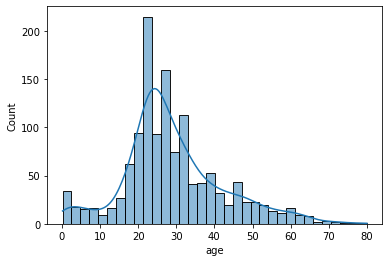

In [117]:
# on peut maintenant évaluer la distribution des Ages sans valeur manquante
import seaborn as sns
sns.histplot(X_df.age, label = "age", kde=True)

### Séparation du jeu d'Entrainement et de Test

In [118]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, random_state = 1)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(981, 3) (328, 3) (981, 1) (328, 1)


## Recherche d'hyperparamètres

### GridSearch pour KNN

Quelles sont les meilleurs variables à considérer pour une classification au moyen d'une classification par voisinnage?

La classification KNeighbors est une classification basée sur les voisins. Elle est un type d'apprentissage non *généralisateur* : c'est à dire qu'elle ne tente pas de construire un modèle généralisable, mais retient les valeurs des instances des données d'apprentissage. La classification est alors calculée à partir d'un simple *vote majoritaire* du voisinnage le plus proches de la cible à classifier.

Pour le Cross-Validation Generator `cv` (le générateur de validation croisée), on a redéfini KFold pour l'exemple. Si on donne une valeur numérique à `cv`, Scikit-Learn utilise KFold avec un paramétrage par défaut.

KFold divise l'ensemble des échantillons en sous-groupes d'échantillons, appelés *plis*, si possible de taille égale. Le model auquel on passe ces `k` plis apprend sur `k-1` plis et le dernier plis est utilisé comme ensemble de test.

In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# hyperparamètre que l'on cherche à optimiser
params = {'n_neighbors': range(1,31),
          'weights': ['uniform', 'distance'],
           'metric': ['euclidean', 'minkowski', 'manhattan']}

# Le Cross-Validation generator
nb_fold = KFold(4, shuffle = True, random_state = 1)

grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid = params, cv = nb_fold)

grid_KNN.fit(Xtrain, ytrain.values.ravel())

GridSearchCV(cv=KFold(n_splits=4, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [122]:
# les paramètres donnant un meilleur score
grid_KNN.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}

In [123]:
# Le meilleur score
grid_KNN.best_score_

0.7727144516343123

In [19]:
model_KNN = grid_KNN.best_estimator_

print(str(round(model_KNN.score(Xtest, ytest), 4)*100) + '%')

75.91%


##  Feature Selection avec Chi2

In [124]:
pds.set_option('display.max_rows', None)

titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [125]:
titanic.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

### séparation du jeu d'Entrainement et de Test

In [24]:
X_bis = titanic.drop(['survived', 'name', 'ticket', 'cabin', 'boat', 'body','home.dest' ], axis = 1)
y_bis = titanic[['survived']]

### Traitement des variables catégorielles en dummies

In [77]:
X_bis = pds.get_dummies(data = X_bis, drop_first = True)
X_bis.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1.0,29.0000,0.0,0.0,211.3375,0.0,0.0,1.0
1,1.0,0.9167,1.0,2.0,151.5500,1.0,0.0,1.0
2,1.0,2.0000,1.0,2.0,151.5500,0.0,0.0,1.0
3,1.0,30.0000,1.0,2.0,151.5500,1.0,0.0,1.0
4,1.0,25.0000,1.0,2.0,151.5500,0.0,0.0,1.0


### Évaluation de la corrélation entre les variables

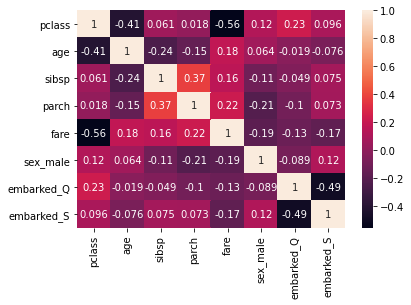

In [26]:
heatmap = sns.heatmap(X_bis.corr(), annot = True)

In [129]:
# Imputation des valeurs manquantes
imp = IterativeImputer(KNeighborsRegressor(n_neighbors = 5))
imp.fit(X_bis)
X_bis = imp.transform(X_bis)
print(f" NaN values: {np.isnan(X_bis).sum()}")

 NaN values: 0


In [130]:
X_bis = pds.DataFrame(X_bis, columns = ['pclass', 'age', 'sibsp', 'parch','fare', 'sex_male', 'embarked_Q', 'embarked_S'])
X_bis.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1.0,29.0000,0.0,0.0,211.3375,0.0,0.0,1.0
1,1.0,0.9167,1.0,2.0,151.5500,1.0,0.0,1.0
2,1.0,2.0000,1.0,2.0,151.5500,0.0,0.0,1.0
3,1.0,30.0000,1.0,2.0,151.5500,1.0,0.0,1.0
4,1.0,25.0000,1.0,2.0,151.5500,0.0,0.0,1.0


### Déterminer les variables à garder

In [134]:
from sklearn.feature_selection import chi2

chi2 , pval = chi2(X_bis, y_bis)

In [132]:
import numpy as np
chi2_stat = pds.DataFrame(np.reshape(chi2, (1,8)), 
                         columns = ['pclass', 'age', 'sibsp', 'parch','fare', 'sex_male', 'embarked_Q', 'embarked_S'])

chi2_stat

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,39.064332,34.879872,2.202718,17.389928,6282.593771,130.254635,0.306335,9.435849


On cherche les variables qui ont un lien avec la cible
Soit le test d'hypothèse:
* $H_0$: la variable sélectionnée est indépendante à la cible
* $H_1$: la variable sélectionnée n'est pas indépendante à la cible

Le seuil pour la p-value est choisi arbitrairement, mais est courament de $0.05$ pour hypothèse de départ et donc $0.95$ pour l'hypothèse opposée.

Si la $p < 0.05$: 
$=>$ Rejet de $H_0$ qui dit que les variables sont indépendantes
$=>$ les variables sont dépendantes

On ne garde que les variables qui ont une p-value inférieur au seuil choisi

In [147]:
features = ['pclass', 'age', 'sibsp', 'parch','fare', 'sex_male', 'embarked_Q', 'embarked_S']
pval_stat = pds.DataFrame(np.reshape(pval, (1,8)), 
                         columns = features)
pval_stat

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,4.100678e-10,3.506876e-09,0.137768,0.00003,0.0,3.604427e-30,0.579938,0.002128


In [149]:
thresh=0.5
mask = pval_stat<thresh

# Variables à garder 
pval_stat.columns[mask.values.ravel()]

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_S'], dtype='object')